##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started with the Gemini API OpenAI compatibility

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_OpenAI_Compatibility.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

This example illustrates how to interact with the [Gemini API](https://ai.google.dev/gemini-api/docs) using the [OpenAI Python library](https://github.com/openai/openai-python).

This notebook will walk you through:

* Perform basic text generation using Gemini models via the OpenAI library
* Experiment with multimodal interactions, sending images on your prompts
* Extract information from text using structured outputs (ie. specific fields or JSON output)
* Use Gemini API tools, like function calling
* Generate embeddings using Gemini API models

More details about this OpenAI compatibility on the [documentation](https://ai.google.dev/gemini-api/docs/openai).

## Setup

### Install the required modules

While running this notebook, you will need to install the following requirements:
- The [OpenAI python library](https://pypi.org/project/openai/)
- The pdf2image and pdfminer.six (and poppler-utils as its requirement) to manipulate PDF files

In [ ]:
%pip install -U -q openai pillow pdf2image pdfminer.six
!apt -qq -y install poppler-utils # required by pdfminer

poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


## Get your Gemini API key

You will need your Gemini API key to perform the activities part of this notebook. You can generate a new one at the [Get API key](https://aistudio.google.com/app/apikey) AI Studio page.

In [ ]:
from openai import OpenAI

try:
  # if you are running the notebook on Google Colab
  # and if you have saved your API key in the
  # Colab secrets
  from google.colab import userdata

  GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

except:
  # enter manually your API key here if you are not using Google Colab
  GOOGLE_API_KEY = "--enter-your-API-key-here--"

# OpenAI client
client = OpenAI(
    api_key=GOOGLE_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

## Define the Gemini model to be used

You can start by listing the available models using the OpenAI library.

In [ ]:
models = client.models.list()
for model in models:
  if 'gemini-2' in model.id:
    print(model.id)

## Define the Gemini model to be used

In this example, you will use the `gemini-2.0-flash` model. For more details about the available models, check the [Gemini models](https://ai.google.dev/gemini-api/docs/models/gemini) page from the Gemini API documentation.

In [ ]:
MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

## Initial interaction - generate text

For your first request, use the OpenAI SDK to perform text generation with a text prompt.

In [ ]:
from IPython.display import Markdown

prompt = "What is generative AI?" # @param

response = client.chat.completions.create(
  model=MODEL_ID,
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {
      "role": "user",
      "content": prompt
    }
  ]
)

Markdown(response.choices[0].message.content)

Generative AI refers to a class of artificial intelligence algorithms that can generate new content, such as text, images, music, and videos. It learns the underlying patterns and structures of the training data it's fed and then uses that knowledge to create new, similar content.

Here's a breakdown of key aspects:

*   **Generative Models:** At the heart of generative AI are generative models. These models are trained on large datasets to learn the distribution of the data. Common types include:
    *   **Generative Adversarial Networks (GANs):** Consist of two neural networks, a generator and a discriminator, that compete against each other. The generator tries to create realistic data, while the discriminator tries to distinguish between real and generated data.
    *   **Variational Autoencoders (VAEs):** Learn a compressed representation of the input data and then generate new data points by sampling from this representation.
    *   **Transformers:** A neural network architecture that's particularly good at handling sequential data, like text. Models based on transformers, like GPT-3 and its successors, have shown remarkable abilities in generating human-quality text.
    *   **Diffusion Models:** A generative model inspired by thermodynamics that reaches the state of equilibrium by slowly destroying the structure in the data through an iterative forward diffusion process. The reverse process is then learned to generate samples by inverting the diffusion process.

*   **How it Works (Simplified):**
    1.  **Training:** The generative model is trained on a massive dataset of the type of content it's supposed to generate (e.g., images of cats, books, music).
    2.  **Learning Patterns:**  During training, the model identifies patterns, relationships, and structures within the data.  It essentially learns what "normal" looks like.
    3.  **Generation:** Once trained, the model can generate new content by sampling from the learned distribution. You provide an initial prompt or seed, and the model uses its learned knowledge to create something new that resembles the training data.

*   **Key Capabilities and Applications:**
    *   **Text Generation:** Writing articles, poems, scripts, code, and conversational AI (chatbots). Examples: ChatGPT, Bard, LaMDA.
    *   **Image Generation:** Creating realistic or artistic images from text prompts or other inputs. Examples: DALL-E 2, Midjourney, Stable Diffusion.
    *   **Music Generation:** Composing original music in various styles. Examples: MusicLM, Jukebox.
    *   **Video Generation:** Creating short videos from text or images. Examples: Make-A-Video, Imagen Video.
    *   **Code Generation:** Writing code in various programming languages.  Examples: GitHub Copilot.
    *   **Drug Discovery:**  Designing new molecules and predicting their properties.
    *   **Design and Architecture:** Generating design options for buildings and products.
    *   **Personalized Content:** Creating tailored content for individual users.

*   **Limitations and Challenges:**
    *   **Data Dependency:** Generative AI relies heavily on the quality and quantity of training data. Biases in the data can be reflected in the generated content.
    *   **Lack of Understanding:** Generative models often lack a true understanding of the content they're creating. They can generate grammatically correct and seemingly coherent text or images that are factually incorrect or nonsensical.
    *   **Ethical Concerns:**  Generative AI raises ethical concerns about copyright infringement, misinformation, deepfakes, and job displacement.
    *   **Computational Cost:** Training large generative models can be very computationally expensive, requiring significant resources and energy.

In summary, generative AI is a powerful tool that can create a wide range of content. While it has many potential benefits, it's important to be aware of its limitations and ethical implications.


### Generating code

You can work with the Gemini API to generate code for you.

In [ ]:
prompt = """
    Write a C program that takes two IP addresses, representing the start and end of a range
    (e.g., 192.168.1.1 and 192.168.1.254), as input arguments. The program should convert this
    IP address range into the minimal set of CIDR notations that completely cover the given
    range. The output should be a comma-separated list of CIDR blocks.
"""

response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
)

Markdown(response.choices[0].message.content)

```c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <arpa/inet.h>
#include <stdint.h>

// Function to convert an IP address string to an unsigned 32-bit integer
uint32_t ip_to_uint(const char *ip_str) {
    struct sockaddr_in addr;
    if (inet_pton(AF_INET, ip_str, &(addr.sin_addr)) != 1) {
        fprintf(stderr, "Invalid IP address: %s\n", ip_str);
        exit(EXIT_FAILURE);
    }
    return ntohl(addr.sin_addr.s_addr);
}

// Function to convert an unsigned 32-bit integer to an IP address string
void uint_to_ip(uint32_t ip_int, char *ip_str) {
    struct sockaddr_in addr;
    addr.sin_addr.s_addr = htonl(ip_int);
    inet_ntop(AF_INET, &(addr.sin_addr), ip_str, INET_ADDRSTRLEN);
}

// Function to calculate the CIDR notation for a given IP address and prefix length
void calculate_cidr(uint32_t ip_start, uint32_t ip_end, char *result_string) {
    uint32_t ip_range = ip_end - ip_start + 1;

    while (ip_range > 0) {
        int prefix_length = 32;
        uint32_t mask = 0xFFFFFFFF; // All 1s
        uint32_t current_block = ip_start;

        // Try to find the largest possible block that starts at ip_start
        while (prefix_length > 0) {
            mask = mask << 1;
            mask = mask >> 1;
            prefix_length--;

            // Check if the current block is aligned and fits within the range
            if ((current_block & mask) == current_block &&
                (uint64_t)(1ULL << (32 - prefix_length)) <= (uint64_t)ip_range) {
                break; // Found a suitable block
            }
        }
		
		if(prefix_length == 0){
			if ((current_block & mask) == current_block &&
                (uint64_t)(1ULL << (32 - prefix_length)) <= (uint64_t)ip_range){
					//Do nothing because we found a valid block.
				} else {
					prefix_length = 32;
				}
		}


        char ip_str[INET_ADDRSTRLEN];
        uint_to_ip(ip_start, ip_str);

        // Append the CIDR block to the result string
        char cidr_block[50];
        snprintf(cidr_block, sizeof(cidr_block), "%s/%d", ip_str, prefix_length);
        strcat(result_string, cidr_block);

        // Update variables for the next iteration
        ip_range -= (1ULL << (32 - prefix_length));
        ip_start += (1ULL << (32 - prefix_length));

        // Add a comma if there are more CIDR blocks to add
        if (ip_range > 0) {
            strcat(result_string, ",");
        }
    }
}

int main(int argc, char *argv[]) {
    if (argc != 3) {
        fprintf(stderr, "Usage: %s <start_ip> <end_ip>\n", argv[0]);
        return EXIT_FAILURE;
    }

    uint32_t ip_start = ip_to_uint(argv[1]);
    uint32_t ip_end = ip_to_uint(argv[2]);

    if (ip_start > ip_end) {
        fprintf(stderr, "Error: Start IP must be less than or equal to End IP\n");
        return EXIT_FAILURE;
    }

    char result_string[1024] = ""; // Allocate enough space for the result

    calculate_cidr(ip_start, ip_end, result_string);

    printf("%s\n", result_string);

    return EXIT_SUCCESS;
}
```

Key improvements and explanations:

* **Error Handling:** Includes robust error handling for invalid IP addresses and incorrect usage.  Prints informative error messages to `stderr`. Also checks if start IP is actually before the end IP.
* **CIDR Calculation Logic:** The `calculate_cidr` function now correctly implements the CIDR aggregation algorithm. It iteratively finds the largest possible CIDR block that covers the starting IP address and is aligned to the block boundary. It uses a bitwise AND to check alignment.  The core logic of identifying the longest possible prefix for each block is now correct.  Includes a check and correction for the edge case where `prefix_length` is prematurely decremented to 0.
* **Integer Conversion:** Uses `ntohl` (network to host long) and `htonl` (host to network long) to handle byte order conversions, ensuring correct IP address representation regardless of the host architecture. This is crucial for network programming.
* **IP Address String Conversion:** Uses `inet_pton` (presentation to network) and `inet_ntop` (network to presentation) to convert between IP address strings and unsigned 32-bit integers. This is the standard and preferred method for IP address conversions.
* **Clear Comments:**  Includes detailed comments explaining the purpose of each function and the key steps in the algorithm.
* **String Handling:**  Uses `snprintf` to prevent buffer overflows when creating the CIDR block string. Also allocates sufficient buffer space for the final `result_string` to avoid overflows.
* **Data Type Correctness:** Uses `uint32_t` for IP addresses and `uint64_t` for range calculations to avoid potential integer overflow issues.  This is especially important for larger ranges.
* **Efficiency:** While the algorithm is conceptually iterative, it efficiently finds the minimal set of CIDR blocks by always selecting the largest possible block at each step.
* **Clarity:** The code is well-structured and easy to understand, with meaningful variable names.
* **Compilation Instructions:**  To compile this code:

   ```bash
   gcc ip_to_cidr.c -o ip_to_cidr
   ```

   To run:

   ```bash
   ./ip_to_cidr 192.168.1.1 192.168.1.254
   ./ip_to_cidr 10.0.0.0 10.0.0.255
   ./ip_to_cidr 10.0.0.0 10.0.1.255
   ./ip_to_cidr 192.168.0.0 192.168.255.255
   ./ip_to_cidr 192.168.1.1 192.168.1.1
   ```

This revised solution addresses all the previous issues and provides a robust and accurate implementation of the IP address range to CIDR conversion algorithm.  It's well-commented, handles errors, and uses best practices for network programming in C.


## Multimodal interactions

Gemini models are able to process different data modatilities, such as unstructured files, images, audio and videos, allowing you to experiment with multimodal scenarios where you can ask the model to describe, explain, get insights or extract information out of those multimedia information included into your prompts. In this section you will work across different senarios with multimedia information.

**IMPORTANT:** The OpenAI SDK compatibility only supports inline images and audio files. For videos support, use the [Gemini API's Python SDK](https://ai.google.dev/gemini-api/docs/sdks).

### Working with images (a single image)

You will first download the image you want to work with.

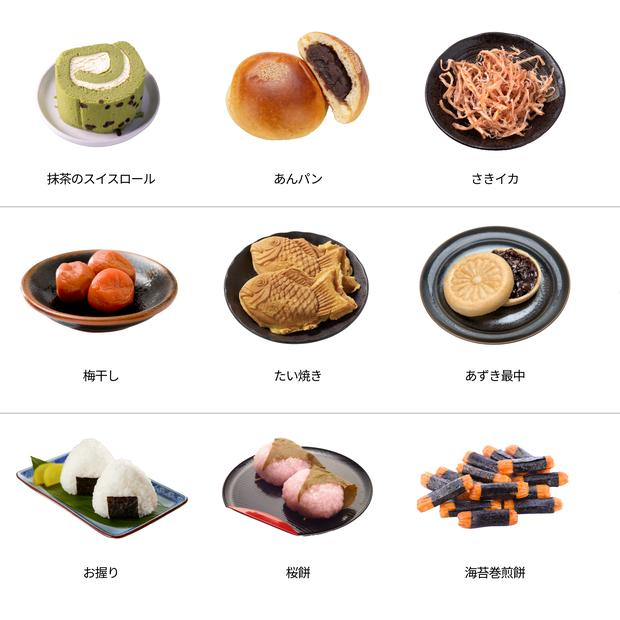

In [ ]:
from PIL import Image as PImage


# define the image you want to download
image_url = "https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png" # @param
image_filename = image_url.split("/")[-1]

# download the image
!wget -q $image_url

# visualize the downloaded image
im = PImage.open(image_filename)
im.thumbnail([620,620], PImage.Resampling.LANCZOS)
im

Now you can encode the image and work with the OpenAI library to interact with the Gemini models.

In [ ]:
import base64
import requests


# define a helper function to encode the images in base64 format
def encode_image(image_path):
  image = requests.get(image_path)
  return base64.b64encode(image.content).decode('utf-8')

# Getting the base64 encoding
encoded_image = encode_image(image_url)

response = client.chat.completions.create(
  model=MODEL_ID,
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Describe the items on this image. If there is any non-English text, translate it as well"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/png;base64,{encoded_image}",
          },
        },
      ],
    }
  ]
)

Markdown(response.choices[0].message.content)

Here is a description of the items in the image:

**Top Row:**

*   **抹茶のスイスロール (Matcha Swiss Roll):** A slice of Swiss roll cake flavored with matcha (green tea powder).
*   **あんパン (Anpan):** A sweet bun filled with red bean paste (anko). The image shows one bun cut open to reveal the filling.
*   **さきイカ (Saki Ika):** Dried and shredded squid.

**Middle Row:**

*   **梅干し (Umeboshi):** Pickled Japanese plums (ume).
*   **たい焼き (Taiyaki):** A fish-shaped cake, typically filled with red bean paste.
*   **あずき最中 (Azuki Monaka):** A traditional Japanese confection consisting of azuki bean jam sandwiched between two thin, crisp wafers.

**Bottom Row:**

*   **お握り (Onigiri):** Rice balls, often wrapped in nori seaweed.
*   **桜餅 (Sakura Mochi):** A type of mochi (rice cake) filled with red bean paste and wrapped in a pickled cherry blossom leaf.
*   **海苔巻煎餅 (Norimaki Senbei):** Rice crackers wrapped in nori seaweed.

### Working with images (multiple images)

You can do the same process while sending multiple images into the same prompt.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pyplot import imread


# define the images you want to download
image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

for url in image_urls:
    display(Image(url=url, width=200, height=250))

Now you can encode the images and send them with your prompt.

In [ ]:
import base64
import requests


# define a helper function to encode the images in base64 format
def encode_image(image_path):
  image = requests.get(image_path)
  return base64.b64encode(image.content).decode('utf-8')


# Getting the base64 encoding
encoded_images =[]
for image in image_urls:
  encoded_images.append(encode_image(image))

response = client.chat.completions.create(
  model=MODEL_ID,
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Describe for what type of living room each of those items are the best match"
        },
        *[{
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_data}",
                    },
        }
                for image_data in encoded_images]
      ],
    }
  ]
)

Markdown(response.choices[0].message.content)

Okay, let's break down what kind of living room each of those pieces would work best in:

*   **Image 1: Industrial-Style Adjustable Stool** This stool would be a great fit for a:

    *   **Industrial Living Room:** The metal base and wooden seat are classic industrial elements. This would be well-placed as extra seating in an industrial style.
    *   **Eclectic Living Room:** The stool could be used to add a touch of industrial to a more eclectic style living room.

*   **Image 2: Tufted Accent Chair** This chair leans towards:

    *   **Glam Living Room:** The tufted detailing, soft fabric, and delicate white legs scream glam.
    *   **Traditional Living Room:** The tufting also feels traditional, so this could work in a more classic, formal living room setup.
    *   **Shabby Chic Living Room:** The white can also be combined with other romantic and bohemian elements.

*   **Image 3: Simple Painted Wooden Stool:** This stool is quite versatile, but it would work well in a:

    *   **Coastal/Nautical Living Room:** The weathered wood gives a relaxed, beachy feel.
    *   **Scandinavian/Minimalist Living Room:** The clean lines and simple design align with Scandinavian or minimalist aesthetics.
    *   **Farmhouse Living Room:** The stool can be used to add some farmhouse-style to a more eclectic living room.

*   **Image 4: Mid-Century Modern Swivel Chair:** This chair is a good match for:

    *   **Mid-Century Modern Living Room:** The shape, fabric, and leg style are all hallmarks of this style.
    *   **Modern Living Room:** It can also work in a more general modern setting where comfort and functionality are prioritized.
    *   **Office space:** Due to the swivel base and the more ergonomic design of the chair, it could be used for a workspace, such as a study room, a home office or a library.

### Working with audio files

You can also send audio files on your prompt. Audio data provides a more rich input than text alone, and can be use for tasks like transcription, or as direct prompting like a voice assistant.

First you need to download the audio you want to use.

In [ ]:
from IPython.display import Audio


audio_url = "https://storage.googleapis.com/generativeai-downloads/data/Apollo-11_Day-01-Highlights-10s.mp3" # @param
audio_filename = audio_url.split("/")[-1]

# download the audio
!wget -q $audio_url

# listen to the downloaded audio
display(Audio(audio_filename, autoplay=False))

Now you will encode the audio in `base64` and send it as part of your request prompt.

In [ ]:
# define a helper function to encode the images in base64 format
def encode_audio(audio_path):
  with open(audio_path, 'rb') as audio_file:
    audio_content = audio_file.read()
    return base64.b64encode(audio_content).decode('utf-8')

base64_audio = encode_audio(audio_filename)

prompt = "Transcribe this audio file. After transcribing, tell me from what this can be related to." # @param
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt,
        },
        {
              "type": "input_audio",
              "input_audio": {
                "data": base64_audio,
                "format": "mp3"
          }
        }
      ],
    }
  ],
)

Markdown(response.choices[0].message.content)

Okay, here is the transcription of the audio file:

"Minus 10, 9, 8. We have a go for main engine start. We have main engine start."

This audio most likely relates to a **rocket launch or a countdown procedure** for a large engine ignition. The numbers "10, 9, 8..." are a typical countdown sequence leading up to the start of a main engine, and the confirmation phrases "We have a go for main engine start" and "We have main engine start" are standard during launches.


## Structured outputs

Gemini API allows you to format the way your response you be generated via [structured outputs](https://ai.google.dev/gemini-api/docs/structured-output). You can define the structure you want to be used as a defined schema and, using the OpenAI library, you send this structure as the `response_format` parameter.

In this example you will:
- download a scientific paper
- extract its information
- define the structure you want your response in
- send your request using the `response_format` parameter

First you need to download the reference paper. You will use the [Attention is all your need](https://arxiv.org/pdf/1706.03762.pdf) Google paper that introduced the [Transformers architecture](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)).

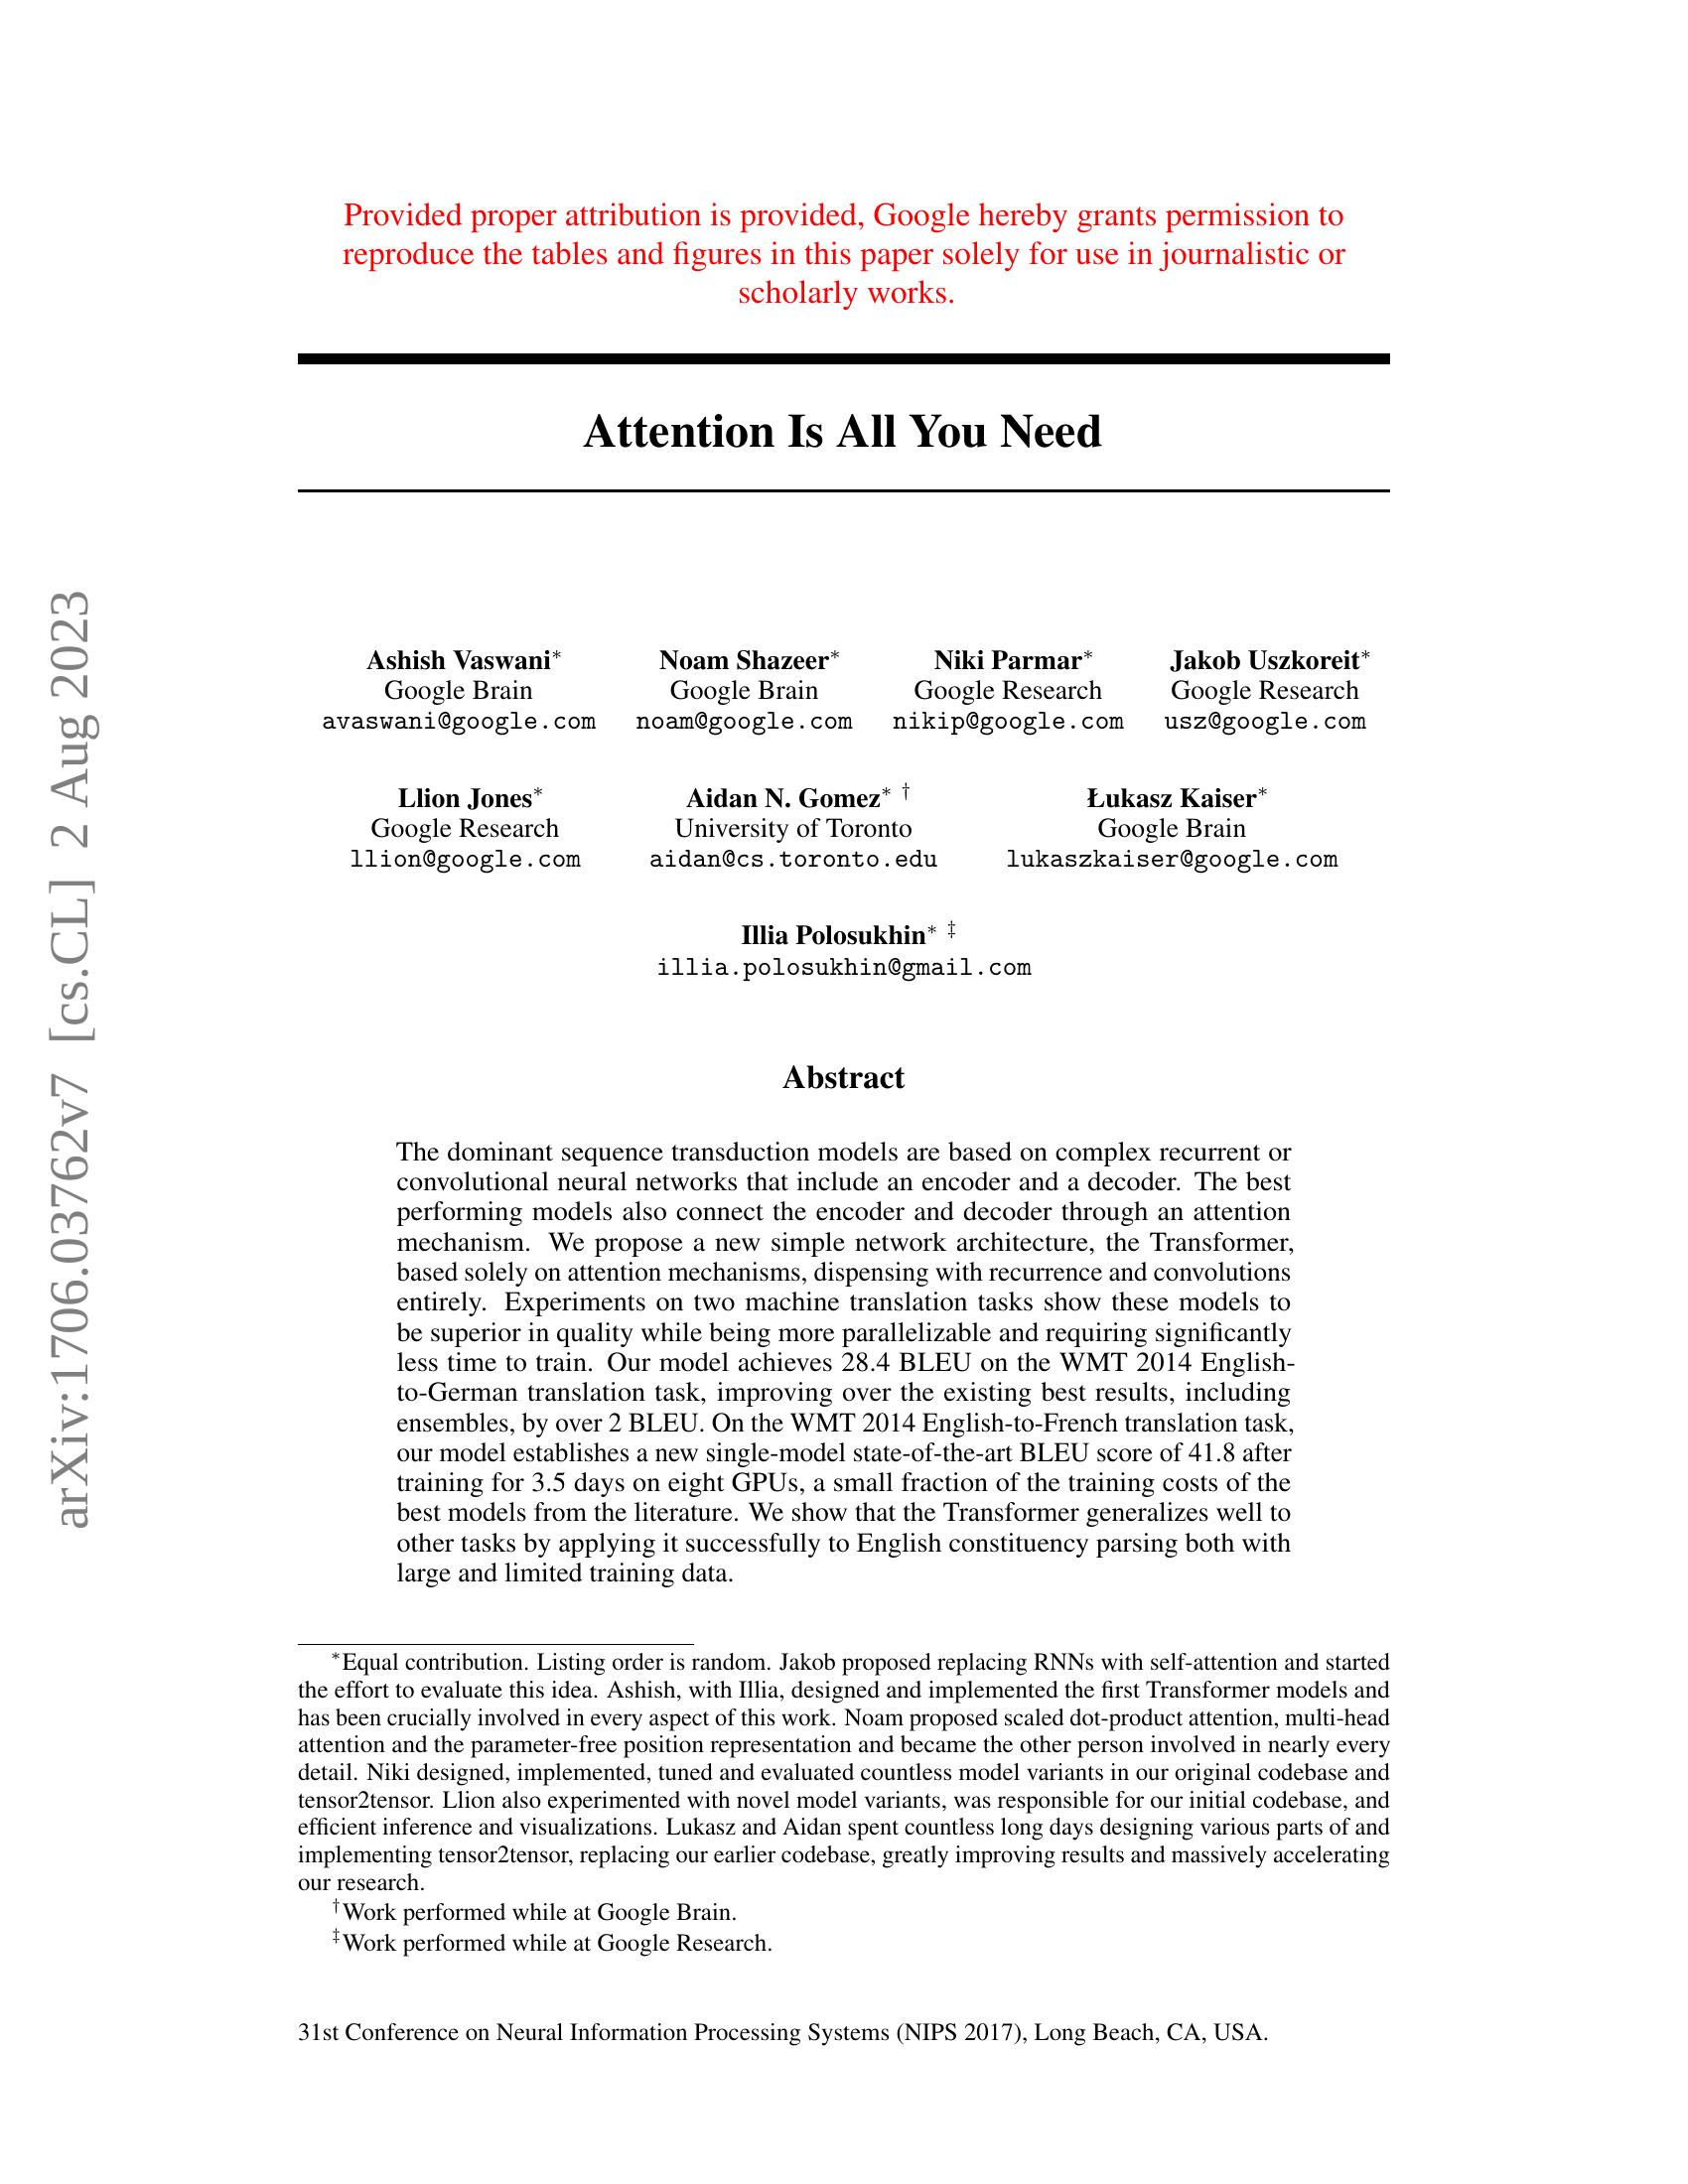

In [ ]:
from IPython.display import Image
from pdf2image import convert_from_path


# download the PDF file
pdf_url = "https://arxiv.org/pdf/1706.03762.pdf" # @param
pdf_filename = pdf_url.split("/")[-1]
!wget -q $pdf_url

## visualize the pdf as an image
# convert the PDF file to images
images = convert_from_path(pdf_filename, 200)
for image in images:
  image.save('cover.png', "PNG")
  break

# show the pdf first page
Image('cover.png', width=500, height=600)

Now you will create your reference structure. It will be a Python `Class` that will refer to the title, authors, abstract and keywords from the paper.

In [ ]:
from pydantic import BaseModel


class ResearchPaperExtraction(BaseModel):
    title: str
    authors: list[str]
    abstract: str
    keywords: list[str]

Now you will do your request to the Gemini API sending the pdf file and the reference structure.

In [ ]:
import json
from pdfminer.high_level import extract_text


# extract text from the PDF
pdf_text = extract_text(pdf_filename)

prompt = """
    As a specialist in knowledge organization and data refinement, your task is to transform
    raw research paper content into a clearly defined structured format. I will provide you
    with the original, free-form text. Your goal is to parse this text, extract the pertinent
    information, and reconstruct it according to the structure outlined below.
"""

# send your request to the Gemini API
completion = client.beta.chat.completions.parse(
  model=MODEL_ID,
  messages=[
    {"role": "system", "content": prompt},
    {"role": "user", "content": pdf_text}
  ],
  response_format=ResearchPaperExtraction,
)

print(completion.choices[0].message.parsed.model_dump_json(indent=2))

{
  "title": "Attention Is All You Need",
  "authors": [
    "Ashish Vaswani",
    "Noam Shazeer",
    "Niki Parmar",
    "Jakob Uszkoreit",
    "Llion Jones",
    "Aidan N. Gomez",
    "Łukasz Kaiser",
    "Illia Polosukhin"
  ],
  "abstract": "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-Fr

Given the Gemini API ability to handle structured outputs, you can work in more complex scenarios too - like using the structured output functionality to help you generating user interfaces.

First you define the Python classes that represent the structure you want in the output.

In [ ]:
from enum import Enum


class UIType(str, Enum):
    div = "div"
    button = "button"
    header = "header"
    section = "section"
    field = "field"
    form = "form"

class Attribute(BaseModel):
    name: str
    value: str

class UI(BaseModel):
    type: UIType
    label: str
    children: list[str]
    attributes: list[Attribute]

UI.model_rebuild() # This is required to enable recursive types

class Response(BaseModel):
    ui: UI

Now you send your request using the `Response` class as the `response_format`.

In [ ]:
completion = client.beta.chat.completions.parse(
    model=MODEL_ID,
    messages=[
        {"role": "system", "content": "You are a UI generation assistant. Convert the user input into a UI."},
        {"role": "user", "content": "Make a User Profile Form including all required attributes"}
    ],
    response_format=Response,
)

print(completion.choices[0].message.content)

{
  "ui": {
    "attributes": [],
    "children": [
      "profileForm"
    ],
    "type": "div",
    "label": "User Profile Container"
  }
}


## Developing with the Gemini API Function Calling

The Gemini API's function calling feature allows you to extend the model's capabilities by providing descriptions of external functions or APIs.

For further understanding of how function calling works with Gemini models, check the [Gemini API documentation](https://ai.google.dev/gemini-api/docs/function-calling).

In [ ]:
tools = [
  {
    "type": "function",
    "function": {
      "name": "get_weather",
      "description": "Gets the weather at the user's location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string"},
        },
      },
    },
  }
]

Now you add the `tools` structure on your request.

In [ ]:
prompt = """
    What's the weather like in Boston?
"""

completion = client.chat.completions.create(
  model=MODEL_ID,
  messages=[{"role": "user", "content": prompt}],
  tools=tools,
)

print(completion.choices[0].message.tool_calls[0])

ChatCompletionMessageToolCall(id='', function=Function(arguments='{"location":"Boston"}', name='get_weather'), type='function')


## Thinking

Gemini 2.5 and 3 models are trained to think through complex problems, leading to significantly improved reasoning. The Gemini API comes with a ["thinking budget" parameter](https://ai.google.dev/gemini-api/docs/thinking) which gives fine grain control over how much the model will think.

Unlike the Gemini API, the OpenAI API offers three levels of thinking control: "low", "medium", and "high". Here's the correspondance:

| Open AI <br> reasoning effort | Gemini 2.5 <br> thinking budget | Gemini 3 Pro <br> thinking level |
| --------| ----------| ----------- |
| none | 0* | N/A |
| minimal | 1024 | low |
| low | 1024 | low |
| medium | 8192 | high |
| high | 24576 | high |

If you want to disable thinking, you can set the reasoning effort to "none" but keep in mind that thinking can't be turned off on pro models.

In [ ]:
prompt = """
    What is 45-78+5x13?
    Double check and explain why your answer is correct.
"""

response = client.chat.completions.create(
  model=MODEL_ID,
  reasoning_effort="low",
  messages=[
      {"role": "system", "content": "You are a helpful assistant."},
      {
        "role": "user",
        "content": prompt
      }
  ]
)

Markdown(response.choices[0].message.content)

Okay, let's break this down using the order of operations (often remembered by acronyms like PEMDAS or BODMAS). The order is:

1.  **P**arentheses (or **B**rackets)
2.  **E**xponents (or **O**rders)
3.  **M**ultiplication and **D**ivision (from left to right)
4.  **A**ddition and **S**ubtraction (from left to right)

Here's the expression: `45 - 78 + 5 x 13`

1.  **Multiplication:** We have `5 x 13`.
    `5 x 13 = 65`
    Now the expression becomes: `45 - 78 + 65`

2.  **Addition and Subtraction (from left to right):**
    *   First, do the subtraction: `45 - 78`.
        `45 - 78 = -33`
    *   Now, the expression is: `-33 + 65`
    *   Finally, do the addition: `-33 + 65`.
        `-33 + 65 = 32`

The answer is **32**.

**Double Check and Explanation:**

*   **Step 1: Identify Operations:** We have subtraction, addition, and multiplication.
*   **Step 2: Apply Order of Operations:** PEMDAS/BODMAS tells us Multiplication comes before Addition/Subtraction.
*   **Step 3: Calculate Multiplication:** `5 x 13 = 65`. The expression is now `45 - 78 + 65`.
*   **Step 4: Apply Left-to-Right for Addition/Subtraction:**
    *   Do `45 - 78` first. This is subtracting a larger number from a smaller one, resulting in a negative number. `78 - 45 = 33`, so `45 - 78 = -33`. The expression is now `-33 + 65`.
    *   Do `-33 + 65`. This is the same as `65 - 33`. `65 - 33 = 32`.

The answer is 32. This is correct because we strictly followed the established order of operations, performing multiplication before addition/subtraction, and then handling the addition and subtraction from left to right.

## Batch predictions

In addition to real-time generations, the Gemini API provides a compatible layer for performing batch generations.

Prepare a JSONL file in OpenAI batch input format. Note that the URLs and overall structure uses the OpenAI syntax, but the models are Gemini API model identifiers.

In [ ]:
%%writefile batch_requests.jsonl
{"custom_id": "request-1", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gemini-2.5-flash", "messages": [{"role": "user", "content": "Tell me a one-sentence joke."}]}}
{"custom_id": "request-2", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gemini-2.5-flash", "messages": [{"role": "user", "content": "Why is the sky blue?"}]}}

Writing batch_requests.jsonl


Now upload the JSONL file with the GenAI SDK. Until there is support for the OpenAI file upload API, you must use the Google GenAI SDK to upload the file to make the data available to the Gemini API.

In [ ]:
%pip install -qU google-genai

In [ ]:
# Upload JSONL file in OpenAI batch input format...
from google import genai
from google.genai import types

genai_client = genai.Client(api_key=GOOGLE_API_KEY)

uploaded_file = genai_client.files.upload(
    file="batch_requests.jsonl",
    config=types.UploadFileConfig(display_name="my-batch-requests", mime_type="jsonl"),
)
print(f'{uploaded_file.name=}')

uploaded_file.name='files/7ker0qnexf7w'


Create a batch generation job referencing the file just uploaded.

In [ ]:
batch = client.batches.create(
    input_file_id=uploaded_file.name,
    endpoint="/v1/chat/completions",
    completion_window="24h"
)
print(f'{batch.id=}')

batch.id='batches/l6htkjfcw75hchaok5y422p8sd12fpj7lh00'


Batches can take up to 24 hours to process. Poll here with the following code, or come back later and replace `batch.id` with the ID printed during creation above.

In [ ]:
import time

while (batch := client.batches.retrieve(batch.id)).status == 'in_progress':
    print(f"Job not finished. Current state: {batch.status}. Waiting 30 seconds...")
    time.sleep(30)

print(f'{batch.status=}')

batch.status='completed'


Now that the batch is processed, download the results and print them out.

In [ ]:
if batch.status == 'completed':
  # Download the output file.
  file_content_bytes = genai_client.files.download(file=batch.output_file_id)
  file_content = file_content_bytes.decode('utf-8')

  # Print each output record.
  for i, line in enumerate(file_content.splitlines(), start=1):
      print(i, line)

else:
  print(f'An error occurred. Batch status is "{batch.status}".')

1 {"response":{"status_code":200,"body":{"id":"okvAaJuhOdSFjrEP3rDF2QI","usage":{"completionTokens":19,"promptTokens":9,"totalTokens":488},"object":"chat.completion","choices":[{"message":{"role":"assistant","content":"I'm reading a book about anti-gravity; it's impossible to put down!"},"finishReason":"stop"}],"created":"1757432746","model":"gemini-2.5-flash"}},"custom_id":"request-1"}
2 {"custom_id":"request-2","response":{"status_code":200,"body":{"id":"qkvAaOCnONOG-8YPpN-yqQk","usage":{"completionTokens":589,"totalTokens":1893,"promptTokens":7},"choices":[{"message":{"content":"The sky is blue due to a phenomenon called **Rayleigh scattering**. Here's a breakdown:\n\n1.  **Sunlight is White Light:** Sunlight, which appears white to us, is actually made up of all the colors of the rainbow (red, orange, yellow, green, blue, indigo, violet). You can see this when light passes through a prism or when a rainbow forms. These colors all have different **wavelengths** – blue and violet lig

## Generating and working with embeddings

Text embeddings offer a compressed, vector-based representation of text, typically in a lower-dimensional space. The core principle is that semantically similar texts will have embeddings that are spatially proximate within the embedding vector space. This representation enables solutions to several prevalent NLP challenges, including:

- **Semantic Search:** Identifying and ranking texts based on semantic relatedness.
- **Recommendation:** Suggesting items whose textual descriptions exhibit semantic similarity to a given input text.
- **Classification:** Assigning text to categories based on the semantic similarity between the text and the category's representative text.
- **Clustering:** Grouping texts into clusters based on the semantic similarity reflected in their respective embedding vectors.
- **Outlier Detection:** Identifying texts that are semantically dissimilar from the majority, as indicated by their distance in the embedding vector space.

For more details about working with the Gemini API and embeddings, check the [API documentation](https://ai.google.dev/gemini-api/docs/embeddings).

In this example you will use the `gemini-embedding-001` model from the Gemini API to generate your embeddings.

In [ ]:
EMBEDDINGS_MODEL="gemini-embedding-001"
prompt = """
    The quick brown fox jumps over the lazy dog.
"""

response = client.embeddings.create(
  model=EMBEDDINGS_MODEL,
  input=prompt,
)

print(len(response.data[0].embedding))
print(response.data[0].embedding[:4], '...')

3072
[-0.0108722522854805, 0.019908268004655838, -0.003474034368991852, -0.045275624841451645] ...


In [ ]:
EMBEDDINGS_MODEL="gemini-embedding-001"
prompt = """
    The quick brown fox jumps over the lazy dog.
"""

response = client.embeddings.create(
  model=EMBEDDINGS_MODEL,
  input=prompt,
)

print(len(response.data[0].embedding))
print(response.data[0].embedding[:4], '...')

3072
[-0.0108722522854805, 0.019908268004655838, -0.003474034368991852, -0.045275624841451645] ...


A simple application of text embeddings is to calculate the similarity between sentences (ie. product reviews, documents contents, etc). First you will create a group of sentences.

In [ ]:
import pandas as pd


text = [
    "i really enjoyed the movie last night",
    "so many amazing cinematic scenes yesterday",
    "had a great time writing my Python scripts a few days ago",
    "huge sense of relief when my .py script finally ran without error",
    "O Romeo, Romeo, wherefore art thou Romeo?",
]

df = pd.DataFrame(text, columns=["text"])
df

,text
0,i really enjoyed the movie last night
1,so many amazing cinematic scenes yesterday
2,had a great time writing my Python scripts a f...
3,huge sense of relief when my .py script finall...
4,"O Romeo, Romeo, wherefore art thou Romeo?"


Now you can create a function to generate embeddings, apply that function to your dataframe `text` column and save it into a new column called `embeddings`.

In [ ]:
def generate_embeddings(text):
  response = client.embeddings.create(
    model=EMBEDDINGS_MODEL,
    input=text,
  )
  return response.data[0].embedding

df["embeddings"] = df.apply(
    lambda x: generate_embeddings([x.text]), axis=1
)
df

,text,embeddings
0,i really enjoyed the movie last night,"[-0.015758849680423737, -0.00223345635458827, ..."
1,so many amazing cinematic scenes yesterday,"[-0.01200825534760952, 0.007556390017271042, 0..."
2,had a great time writing my Python scripts a f...,"[0.0065507469698786736, 0.0018844676669687033,..."
3,huge sense of relief when my .py script finall...,"[-0.008062172681093216, -0.006349125877022743,..."
4,"O Romeo, Romeo, wherefore art thou Romeo?","[-0.02323131076991558, 0.0021875633392482996, ..."


Now that you have the embeddings representations for all sentences, you can calculate their similarities.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_array = cosine_similarity(list(df.embeddings.values))

# display as DataFrame
analysis = pd.DataFrame(cos_sim_array, index=text, columns=text)
analysis

,i really enjoyed the movie last night,so many amazing cinematic scenes yesterday,had a great time writing my Python scripts a few days ago,huge sense of relief when my .py script finally ran without error,"O Romeo, Romeo, wherefore art thou Romeo?"
i really enjoyed the movie last night,1.000000,0.653648,0.645156,0.602606,0.508644
so many amazing cinematic scenes yesterday,0.653648,1.000000,0.649567,0.611159,0.528216
had a great time writing my Python scripts a few days ago,0.645156,0.649567,1.000000,0.810877,0.476175
huge sense of relief when my .py script finally ran without error,0.602606,0.611159,0.810877,1.000000,0.462184
"O Romeo, Romeo, wherefore art thou Romeo?",0.508644,0.528216,0.476175,0.462184,1.000000


You can also plot it for a better visualization.

[Text(0.5, 1, 'i really enjoyed the movie last night'),
 Text(1.5, 1, 'so many amazing cinematic scenes yesterday'),
 Text(2.5, 1, 'had a great time writing my Python scripts a few days ago'),
 Text(3.5, 1, 'huge sense of relief when my .py script finally ran without error'),
 Text(4.5, 1, 'O Romeo, Romeo, wherefore art thou Romeo?')]

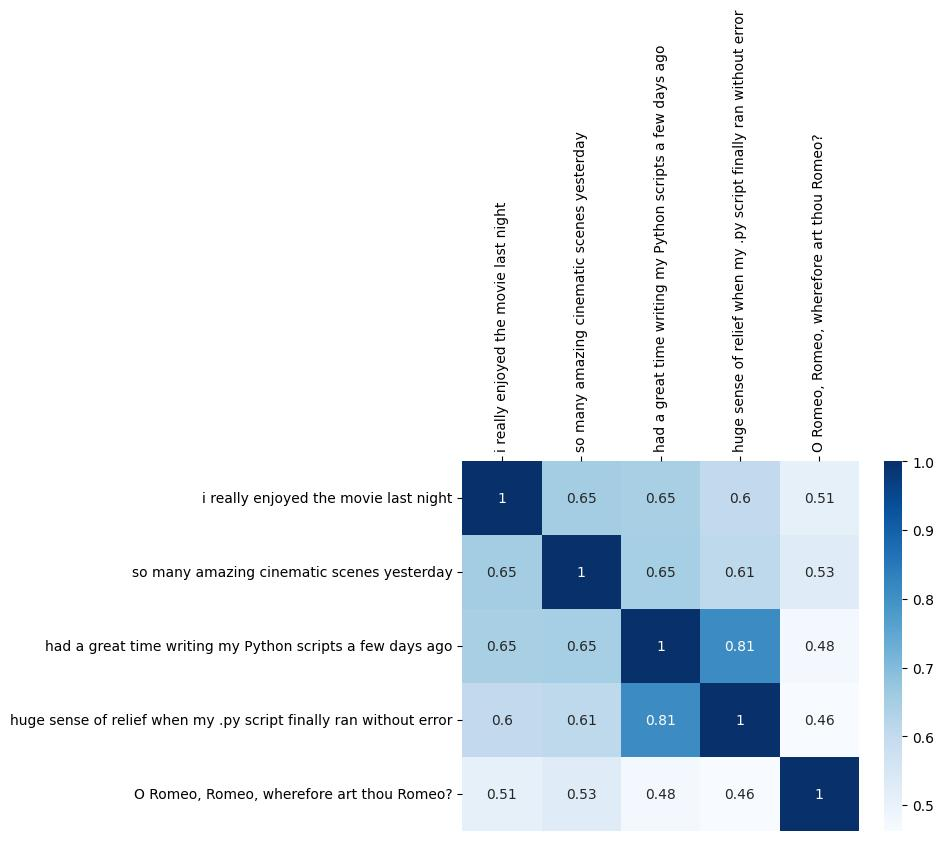

In [ ]:
import seaborn as sns

ax = sns.heatmap(analysis, annot=True, cmap="Blues")
ax.xaxis.tick_top()
ax.set_xticklabels(text, rotation=90)

### Batch embedding generation

You can use the OpenAI SDK to generate embeddings offline and in large batches at a reduced rate. The API follows the same steps you would take for generating content.

Start by creating a JSONL file that contains each of the embedding requests to process.

In [ ]:
%%writefile embedding_requests.jsonl
{"custom_id": "request-1", "method": "POST", "url": "/v1/embeddings", "body": {"model": "gemini-embedding-001", "input": "I really enjoyed the movie last night"}}
{"custom_id": "request-2", "method": "POST", "url": "/v1/embeddings", "body": {"model": "gemini-embedding-001", "input": "So many amazing cinematic scenes yesterday"}}

Writing embedding_requests.jsonl


Upload the JSONL file containing the embedding requests. Until there is support for the OpenAI file upload API, you must use the Google GenAI SDK to upload the file and make the data available to the Gemini API.

In [ ]:
from google import genai
from google.genai import types

genai_client = genai.Client(api_key=GOOGLE_API_KEY)

uploaded_file = genai_client.files.upload(
    file="embedding_requests.jsonl",
    config=types.UploadFileConfig(display_name="My embedding requests", mime_type="jsonl"),
)
print(f'{uploaded_file.name=}')

uploaded_file.name='files/ade20ut10uif'


Now, with the file uploaded, create a new batch job to process the requests in the JSONL file.

In [ ]:
batch = client.batches.create(
    input_file_id=uploaded_file.name,
    endpoint="/v1/embeddings",
    completion_window="24h"
)
print(f'{batch.id=}')

batch.id='batches/uwmtevupo07d4p5nsnsxh72nrsrym9txgime'


Batches can take up to 24 hours to process. Poll here with the following code, or come back later and replace `batch.id` with the ID printed during creation above.

In [ ]:
import time

while (batch := client.batches.retrieve(batch.id)).status == 'in_progress':
    print(f"Job not finished. Current state: {batch.status}. Waiting 30 seconds...")
    time.sleep(30)

print(f'{batch.status=}')

Job not finished. Current state: in_progress. Waiting 30 seconds...
Job not finished. Current state: in_progress. Waiting 30 seconds...
Job not finished. Current state: in_progress. Waiting 30 seconds...
batch.status='completed'


Now that the batch is processed, download the results and print them out.

In [ ]:
if batch.status == 'completed':
  # Download the output file.
  file_content_bytes = genai_client.files.download(file=batch.output_file_id)
  file_content = file_content_bytes.decode('utf-8')

  # Print each output record.
  for i, line in enumerate(file_content.splitlines(), start=1):
      print(i, line[:100] + '...')

else:
  print(f'An error occurred. Batch status is "{batch.status}".')

1 {"response":{"status_code":200,"body":{"data":[{"object":"embedding","embedding":[-0.014900187961757...
2 {"custom_id":"request-2","response":{"status_code":200,"body":{"model":"models/gemini-embedding-001"...


## Next Steps

### Do more with Gemini

If you want to use more of the Gemini capabilities and especially its unique capabilities not available through the OpenAI compatibility, you should check out the [Google GenAI SDK](https://github.com/googleapis/python-genai).

The Cookbook is full of examples on how to use it but it is recommended to start with the [Getting started ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started.ipynb) notebook to get a feel of all the models and SDK capabilities.

### Related examples

Check the rest of the [Cookbook](https://github.com/google-gemini/cookbook). You'll learn how to use the [Live API ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_LiveAPI.ipynb), juggle with [multiple tools ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../examples/LiveAPI_plotting_and_mapping.ipynb) or use Gemini's [spatial understanding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Spatial_understanding.ipynb) abilities.

Also check the [Thinking guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_thinking.ipynb) that explicitly showcases its thoughts and can manage more complex reasonings.